# Predicting Stroke Susceptibility: Enhancing Preventive Healthcare Measures through Advanced Data Analytics

Strokes pose a critical public health challenge, with their incidence surpassing that of cancer-related fatalities annually. The timely identification of individuals at high risk for strokes is crucial for implementing preemptive interventions and ultimately reducing the incidence of strokes. This project aims to leverage current biometric data and other factors to develop predictive models that accurately forecast patients with a high susceptibility to stroke. By enhancing preventive measures, we aim to mitigate the incidence of strokes in the future.

### Importing and Reading Data

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from statannotations.Annotator import Annotator
from sklearn.preprocessing import LabelEncoder

In [15]:
#importing data
df = pd.read_csv('strokesdataset.csv')

In [93]:
#Preview data
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,formerly smoked,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,43400.0,36326.142350,21072.134879,1.00,18038.50,36351.50,54514.25,72943.00
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
hypertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
heart_disease,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
stroke,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


The stroke dataset consists of 43,400 entries, each providing detailed health and demographic information for individuals. This dataset includes 12 columns capturing various factors that may influence stroke risk. Key attributes include gender, age, hypertension status, heart disease status, marital status, work type, residence type, average glucose level, body mass index (BMI), smoking status, and stroke occurrence.

A notable aspect of the dataset is its completeness, with most columns having non-null values for all 43,400 entries. However, there are some missing values in the BMI and smoking status columns. This missing data will be addressed to ensure the robustness of any predictive models developed.

Interestingly, the dataset reveals that 1.80% of the individuals have had a stroke. This relatively low incidence highlights the importance of developing precise predictive models to identify those at higher risk effectively. Such models could significantly impact preventive healthcare measures by enabling timely and targeted interventions.

## Data Wrangling

In [19]:
#Identify missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
smoking_status,13292,30.626728
bmi,1462,3.368664
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000


Handling missing data appropriately will be crucial to ensure the accuracy and reliability of our predictive models. We can consider techniques such as imputation or exclusion based on the extent of missingness and the nature of the dataset.

For the 'smoking_status' column with >30% missing data:
Since 'smoking_status' is a categorical variable, we can replace missing values with random values in the given ratio of our current data.

For the 'bmi' column with >3.3% missing data:
Since 'bmi' is a numerical variable, we can replace missing values with the median of the column, which is less sensitive to outliers compared to the mean. 

In [20]:
#Fill in missing values for smoking_status using same ratios already found in dataset
ratios = {'never smoked': 53.3, 'formerly smoked': 24.9, 'smokes': 21.8}

# Function to fill missing values based on given ratios
def fill_missing_smoking(row):
    if pd.isna(row['smoking_status']):
        return np.random.choice(list(ratios.keys()), p=[v/100 for v in ratios.values()])
    else:
        return row['smoking_status']

# Apply function to fill missing values
df['smoking_status'] = df.apply(fill_missing_smoking, axis=1)

In [21]:
#Fill in missing values for BMI column using median
def fill_missing_bmi(row):
    if pd.isna(row['bmi']):
        return df['bmi'].median()
    else:
        return row['bmi']

# Apply function to fill missing values
df['bmi'] = df.apply(fill_missing_bmi, axis=1)

In [22]:
#Evaluate misssing data counts
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
id,0,0.0
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0


We have successfully filled in our missing values. Next we will remove any unessecary columns, such as the 'id' ciolumn as it doesn't provide any additional infomation.

In [23]:
#Drop 'id' column
df = df.drop(columns=['id'])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,formerly smoked,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,0


Now that we have cleaned up our data we can now perform EDA to see what kind of patterns or insights the data provides that can help us determine what information will be beneficial to building successsful models. 

## EDA

The Exploratory Data Analysis (EDA) section serves as a critical first step in understanding and interpreting the stroke dataset. This phase involves a thorough examination of the dataset to uncover initial insights, detect patterns, and identify anomalies. EDA is essential for shaping subsequent analysis and modeling efforts, ensuring that the data is accurately represented and appropriately prepared for predictive modeling.

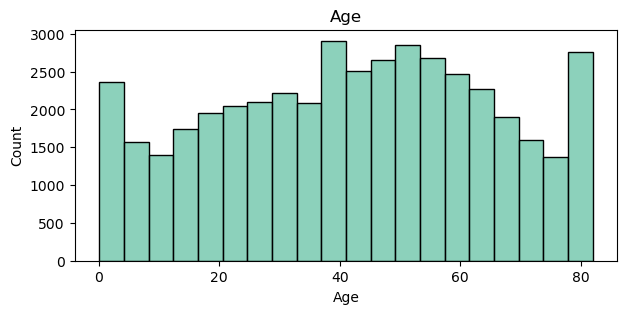

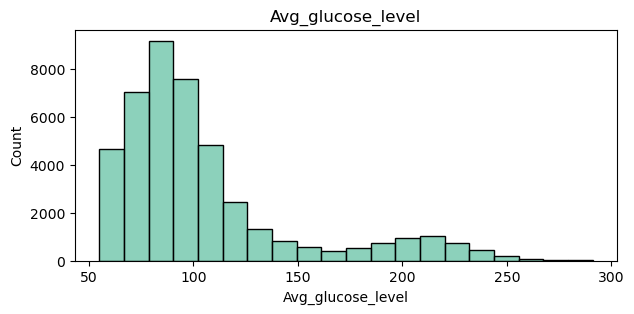

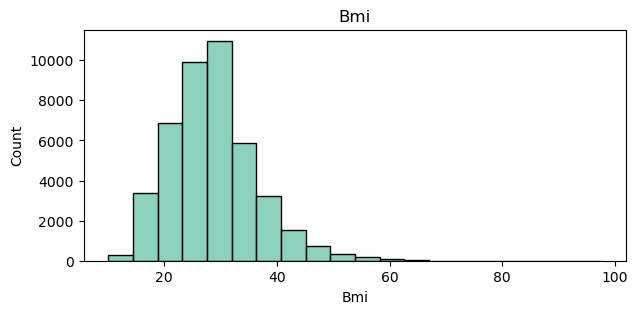

In [48]:
# List of numerical columns to plot
columns = ['age', 'avg_glucose_level', 'bmi']

# Plot each column
for column in columns:
    plt.figure(figsize=(7, 3))
    sns.histplot(data=df, x=column, bins=20, kde=False, color=sns.color_palette("Set2")[0])
    plt.title(column.capitalize())
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')

The age distribution shows a relatively uniform spread across different age groups, with notable peaks around the ages of 0 and 80. This balance ensures comprehensive age representation, allowing for age-specific risk analysis. The high count of elderly individuals, who are at greater risk for stroke, is particularly significant. These insights enable targeted interventions for various age groups based on their unique risk profiles, thereby enhancing the effectiveness of preventive measures and predictive modeling efforts.


The average glucose level distribution reveals that most individuals have glucose levels between 80-100 mg/dL, which is within the normal range. The right-skewed distribution indicates a smaller subset of the population with elevated glucose levels, suggesting potential pre-diabetes or diabetes cases. Outliers with very high glucose levels further emphasize the necessity of monitoring and managing glucose to mitigate stroke risk. This distribution is crucial for identifying individuals at higher risk and developing targeted health interventions.

The histogram of BMI (Body Mass Index) indicates a roughly normal distribution, peaking around the 25-30 range, which is classified as normal to overweight. This distribution suggests that most individuals fall within this standard BMI range, with fewer cases of severe obesity. The slight right skew and presence of outliers with extremely high BMI values highlight the need for targeted interventions to address obesity-related risks, including stroke. These observations highlights BMI's importance as a significant feature in predictive models for stroke risk.

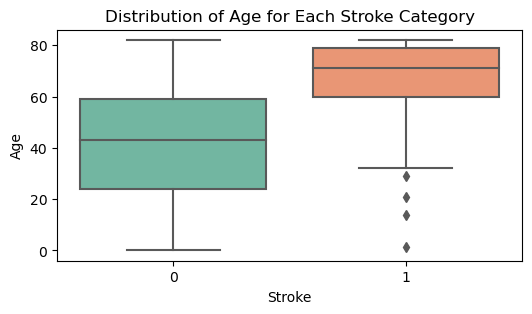

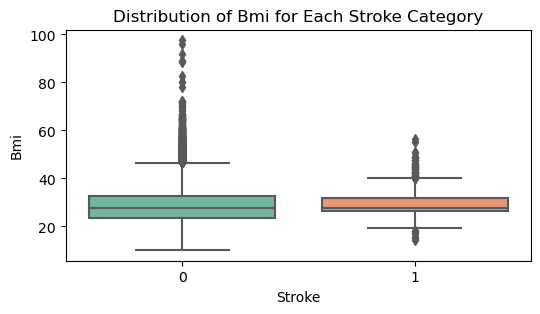

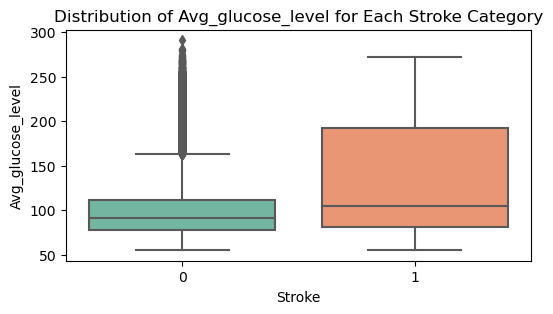

In [39]:
# List of numerical columns to plot
columns = ['age', 'bmi', 'avg_glucose_level']

# Plot each column
for i, column in enumerate(columns):
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='stroke', y=column, data=df, palette=sns.color_palette("Set2"))
    plt.title(f'Distribution of {column.capitalize()} for Each Stroke Category')
    plt.xlabel('Stroke')
    plt.ylabel(column.capitalize())
    plt.show()

In [64]:
# Define groups for stroke and non-stroke
G1 = df[df['stroke'] == 1]  # People who have had a stroke
G2 = df[df['stroke'] == 0]  # People who have not had a stroke

# Perform t-tests for age, bmi, and avg_glucose_level
age_ttest = stats.ttest_ind(G1['age'], G2['age'])
bmi_ttest = stats.ttest_ind(G1['bmi'], G2['bmi'])
glucose_ttest = stats.ttest_ind(G1['avg_glucose_level'], G2['avg_glucose_level'])

print(f"Age T-Test: Statistic={age_ttest.statistic}, P-value={age_ttest.pvalue}")
print(f"BMI T-Test: Statistic={bmi_ttest.statistic}, P-value={bmi_ttest.pvalue}")
print(f"Avg Glucose Level T-Test: Statistic={glucose_ttest.statistic}, P-value={glucose_ttest.pvalue}")

Age T-Test: Statistic=32.91160061215167, P-value=1.1715396598877709e-234
BMI T-Test: Statistic=3.3488046716890953, P-value=0.0008123003046563606
Avg Glucose Level T-Test: Statistic=16.49159150818717, P-value=6.466046156595364e-61


#### Age Distribution and T-Test
The box plot for age distribution indicates that individuals who have experienced a stroke are generally older, with a median age of around 70 compared to about 45 for those who have not had a stroke. This observation is strongly supported by the age T-Test, which resulted in a statistic of 32.91 and an extremely small p-value (1.17e-234). The high test statistic and the near-zero p-value indicate a significant difference in the age distributions between the two groups. This confirms that age is a highly significant factor in stroke risk, reinforcing the need for targeted preventive measures for older populations.

#### BMI Distribution and T-Test
The box plot for BMI distribution shows that the median BMI is similar between stroke and non-stroke groups, though there are more extreme BMI values among those without a stroke. The BMI T-Test yielded a statistic of 3.35 and a p-value of 0.0008. While this p-value is much higher than those for age and glucose levels, it still indicates a statistically significant difference between the two groups. This suggests that BMI does have a role in stroke risk, though it may be influenced by other health and lifestyle factors. Therefore, BMI should be considered as part of a multifactorial risk assessment rather than as a standalone predictor.

#### Average Glucose Level Distribution and T-Test
The average glucose level distribution box plot shows a clear difference, with stroke patients having higher glucose levels. The T-Test for average glucose levels supports this visual observation, with a statistic of 16.49 and a p-value of 6.47e-61. This extremely small p-value confirms that the difference in glucose levels between stroke and non-stroke individuals is highly significant. Elevated glucose levels are a critical risk factor for stroke, emphasizing the importance of glucose monitoring and management in stroke prevention strategies.

Based on the t-test results:

Age: The extremely high t-statistic and near-zero p-value suggest a significant difference in age between those who have had a stroke and those who have not. Age appears to be a strong factor.

BMI: The t-statistic and low p-value indicate a statistically significant difference in BMI between the groups, but the effect may be smaller compared to age.

Avg Glucose Level: The high t-statistic and very low p-value suggest a significant difference in average glucose levels between stroke and non-stroke groups, indicating that glucose level is also a strong factor.

Overall, these results suggest that age, BMI, and average glucose level are significant predictors of stroke occurrence.

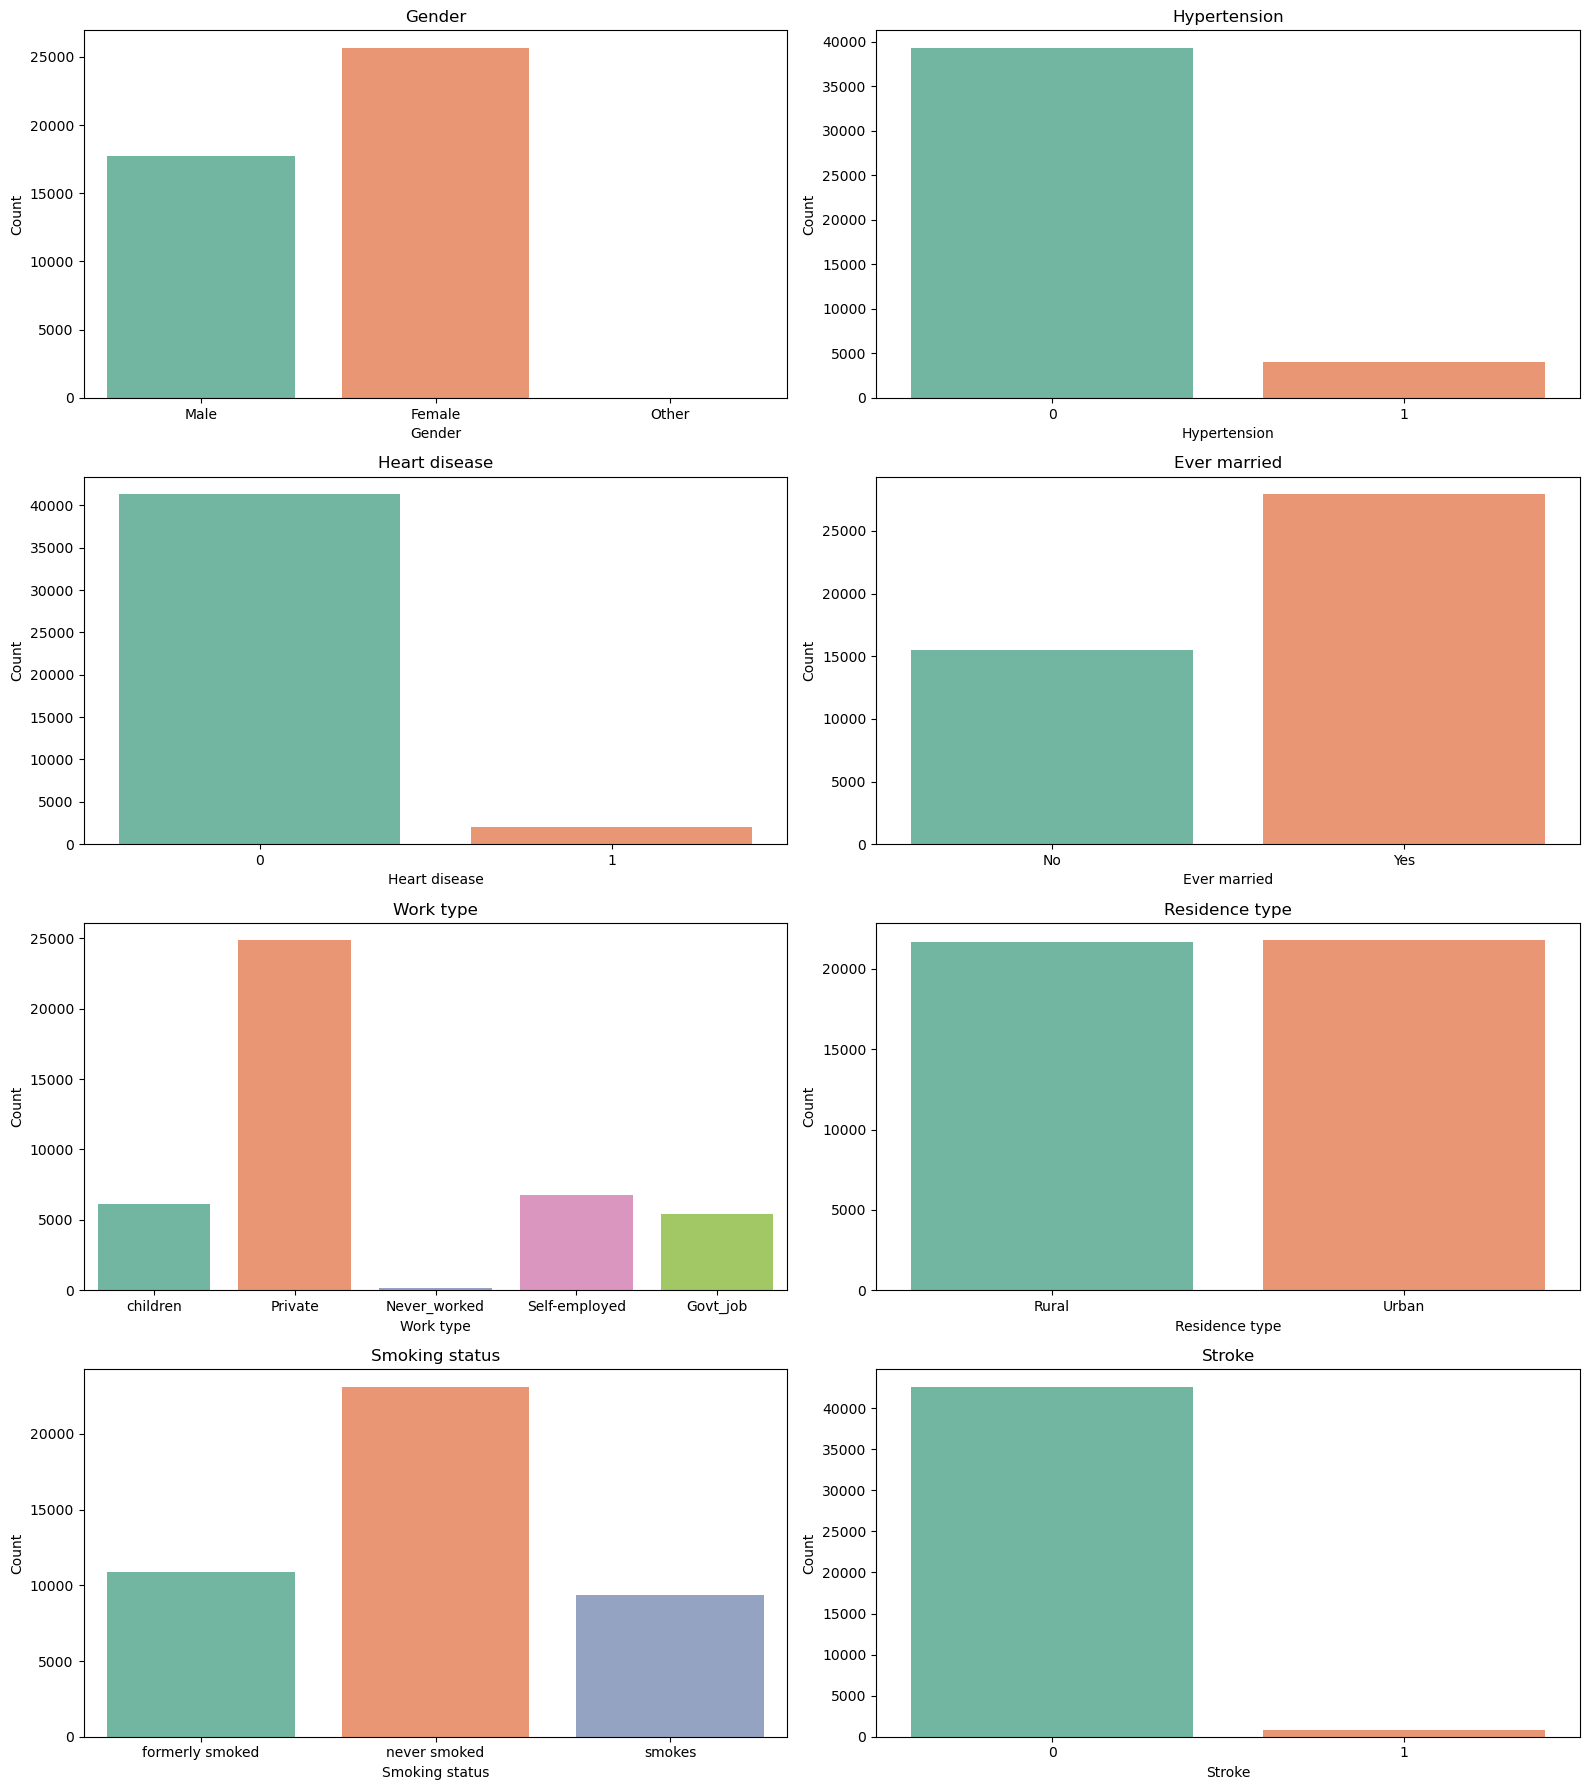

In [50]:
# List of categorical columns to plot
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Set up the plot grid
fig, axes = plt.subplots(nrows=(len(categorical_columns) + 1) // 2, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, x=column, ax=axes[i], palette=sns.color_palette("Set2"))
    axes[i].set_title(column.replace('_', ' ').capitalize())
    axes[i].set_xlabel(column.replace('_', ' ').capitalize())
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

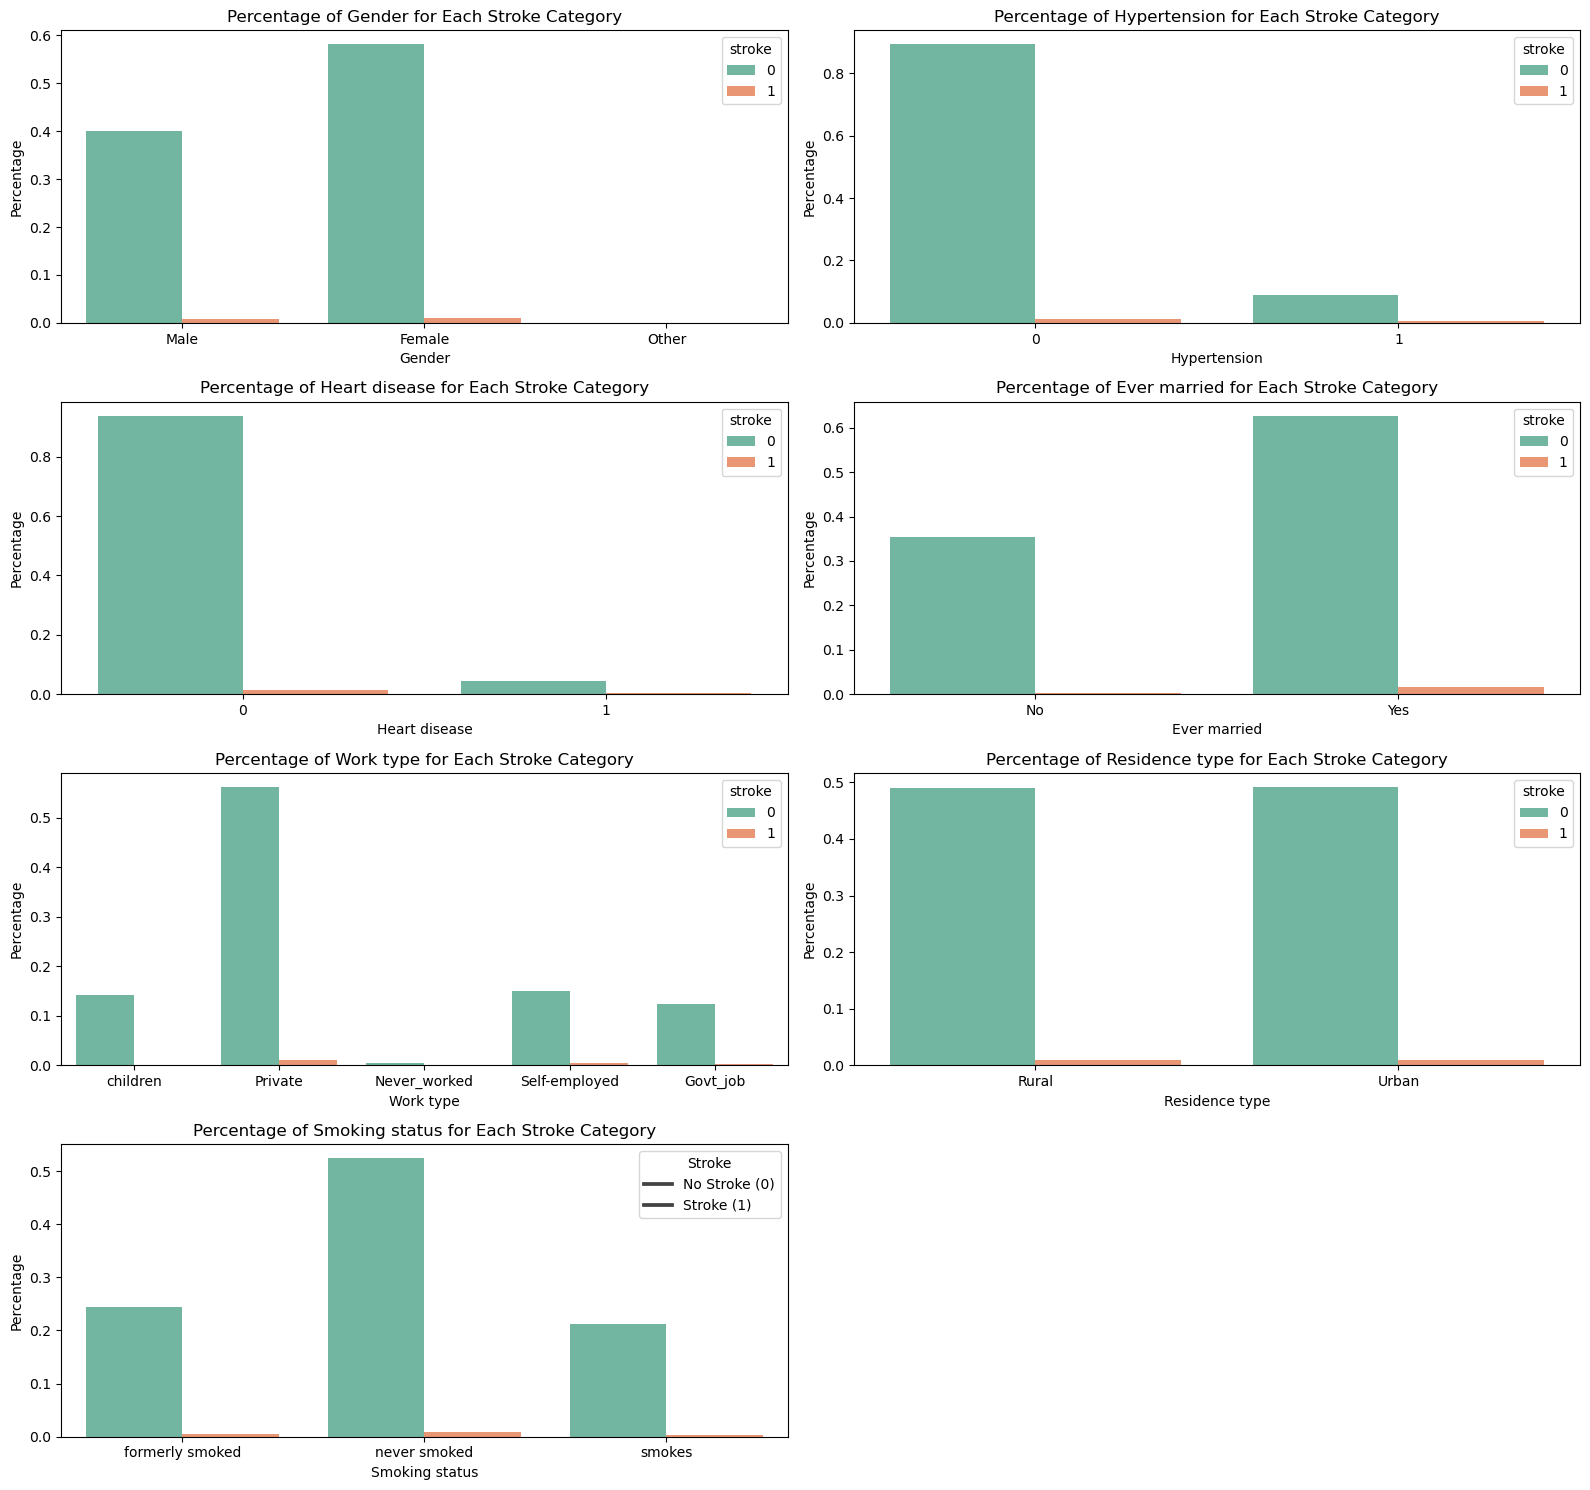

In [58]:
# List of categorical columns to plot
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Set up the plot grid
num_plots = len(categorical_columns)
fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(16, 15))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.barplot(x=column, y='stroke', data=df, estimator=lambda x: len(x) / len(df), hue='stroke', ax=axes[i], palette=sns.color_palette("Set2"))
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel(column.replace("_", " ").capitalize())
    axes[i].set_title(f'Percentage of {column.replace("_", " ").capitalize()} for Each Stroke Category')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.legend(title='Stroke', loc='upper right', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()

Gender: There appears to be a higher proportion of strokes in males compared to females, though both groups have a small percentage of strokes overall.

Hypertension and Heart Disease: Individuals with hypertension or heart disease show a higher percentage of strokes, but these conditions are still rare among stroke patients.

Ever Married: There is a slight increase in stroke percentage among those who are married, but it remains low.

Work Type: The private sector shows a higher count of individuals with strokes, but overall, strokes are rare across all work types.

Residence Type: There seems to be no significant difference in stroke occurrences between rural and urban areas.

Smoking Status: Those who currently smoke or have smoked show a slightly higher percentage of strokes, but the overall stroke count is low in all categories.

Overall, while certain factors like hypertension, heart disease, and smoking appear to be associated with stroke occurrences, the percentages are generally low, suggesting that these factors may be part of a broader set of risk indicators. Further statistical analysis would be needed to confirm these relationships.

In [65]:
# Define groups for stroke and non-stroke
G1 = df[df['stroke'] == 1]  # People who have had a stroke
G2 = df[df['stroke'] == 0]  # People who have not had a stroke

# Perform t-tests for hypertension and heart disease
hypertension_ttest = stats.ttest_ind(G1['hypertension'], G2['hypertension'])
heart_disease_ttest = stats.ttest_ind(G1['heart_disease'], G2['heart_disease'])

print(f"Hypertension T-Test: Statistic={hypertension_ttest.statistic}, P-value={hypertension_ttest.pvalue}")
print(f"Heart Disease T-Test: Statistic={heart_disease_ttest.statistic}, P-value={heart_disease_ttest.pvalue}")

Hypertension T-Test: Statistic=15.738074583072663, P-value=1.1826077404516636e-55
Heart Disease T-Test: Statistic=23.85417055505082, P-value=5.861945318017253e-125


Based on the t-test results:

Hypertension: The high t-statistic and extremely low p-value suggest a significant difference in hypertension status between those who have had a stroke and those who have not. Hypertension appears to be a strong predictor of stroke.

Heart Disease: The very high t-statistic and near-zero p-value indicate a significant difference in heart disease status between the groups, suggesting that heart disease is also a strong factor associated with stroke.

These findings reinforce the importance of both hypertension and heart disease as significant factors in stroke occurrence.

In [66]:
# List of categorical variables
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Perform Chi-Squared Test for each variable
for column in categorical_columns:
    contingency_table = pd.crosstab(df[column], df['stroke'])
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {column}:")
    print("Chi-Square Statistic:", chi2_stat)
    print("p-value:", p_val)
    print()

Chi-Square Test for gender:
Chi-Square Statistic: 5.767894799445178
p-value: 0.05591361325694649

Chi-Square Test for ever_married:
Chi-Square Statistic: 223.3560107615051
p-value: 1.6763961138161355e-50

Chi-Square Test for work_type:
Chi-Square Statistic: 250.38868189317367
p-value: 5.368196953306683e-53

Chi-Square Test for Residence_type:
Chi-Square Statistic: 0.1866443482985896
p-value: 0.6657242966461914

Chi-Square Test for smoking_status:
Chi-Square Statistic: 22.585067270189242
p-value: 1.2465650763457062e-05



Based on the chi-square test results:

Gender: The p-value is slightly above the conventional threshold of 0.05, suggesting no significant association between gender and stroke.

Ever Married: The very low p-value indicates a significant association between marital status and stroke occurrence.

Work Type: The extremely low p-value suggests a strong association between work type and stroke status.

Residence Type: The high p-value indicates no significant association between residence type and stroke.

Smoking Status: The low p-value suggests a significant association between smoking status and stroke occurrence.

Overall, ever married, work type, and smoking status are significantly associated with stroke, while gender and residence type are not.

### Feature Importance

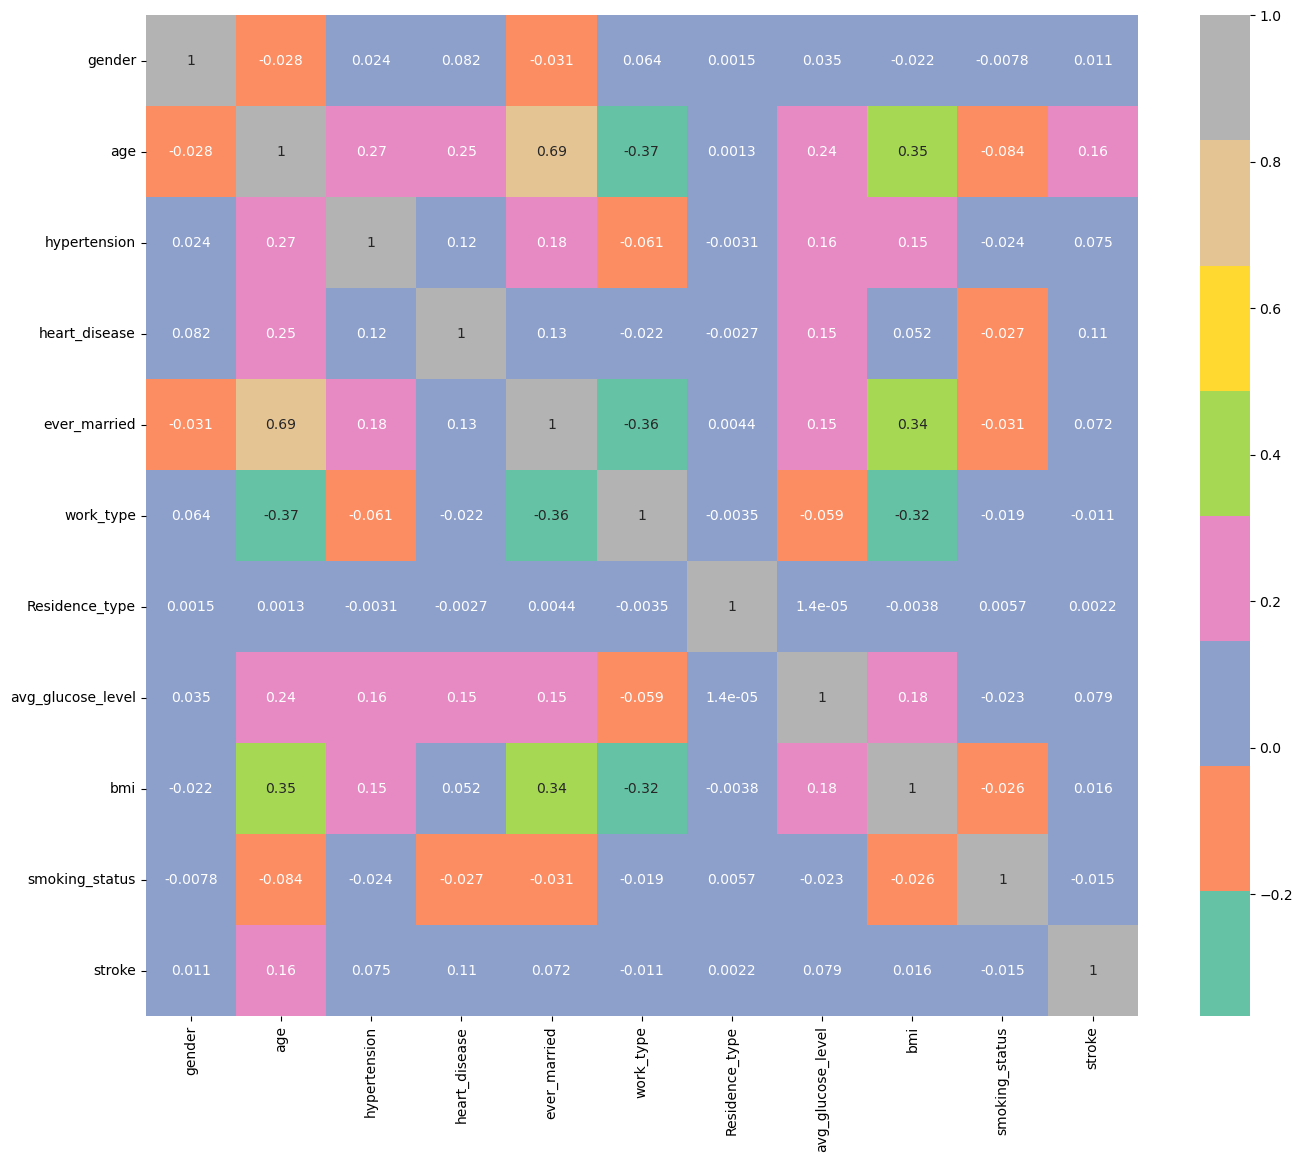

In [68]:
# Encode categorical variables
corr_data = df.copy()
encoder = LabelEncoder()
for col in corr_data.select_dtypes(include="object").columns:
    corr_data[col] = encoder.fit_transform(corr_data[col])

# Plot heatmap with "Set2" color scheme
plt.figure(figsize=(16, 13))
sns.heatmap(data=corr_data.corr(), annot=True, cmap=sns.color_palette("Set2", as_cmap=True))
plt.show()


Based on the heatmap:

Age and Stroke: There is a noticeable correlation, consistent with the strong t-test results.
Hypertension and Stroke: Shows some correlation, aligning with the significant t-test result.
Heart Disease and Stroke: Shows a moderate correlation, also matching the significant t-test result.
BMI and Stroke: There is a slight correlation, which corresponds to the t-test result indicating significance.
Smoking Status and Stroke: Shows a weak correlation but aligns with the chi-square test indicating some significance.
Ever Married and Work Type: Low correlation with stroke, reflecting the chi-square results.

Overall, the heatmap supports the findings from the statistical tests and visualizations, highlighting significant factors associated with stroke.

## Data Transformation

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

In [71]:
#Split data into positive stoke and negative
had_stroke = df[df["stroke"]==1]
no_stroke = df[df["stroke"]==0]

#resample data 
resampled_had_stroke = resample(had_stroke,replace=True , n_samples=no_stroke.shape[0] , random_state=123 )
resampled_data = pd.concat([no_stroke,resampled_had_stroke])

In [72]:
#Make dummy variables for categorical columns
cols = ['gender','hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status']
dummy = pd.get_dummies(resampled_data[cols],dtype=int)
updated_df = pd.concat([resampled_data,dummy],axis=1).drop(columns=cols)

In [73]:
encoder = LabelEncoder()
updated_df["age"] = encoder.fit_transform(updated_df["age"])

In [74]:
# Select columns to scale
cols_to_scale = ['age', 'avg_glucose_level', 'bmi']

# Create a new DataFrame for scaled data
scaled_data = updated_df.copy()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform selected columns
scaled_data[cols_to_scale] = scaler.fit_transform(scaled_data[cols_to_scale])

# Display preview of scaled data
scaled_data

,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.233010,0.169964,0.090286,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0
1,0.766990,0.139631,0.332571,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
2,0.281553,0.236772,0.085714,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0
3,0.883495,0.059479,0.294857,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0.339806,0.450244,0.102857,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5412,0.922330,0.184495,0.177143,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
23936,0.864078,0.518068,0.228571,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
3712,0.854369,0.029401,0.173714,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1
6701,0.864078,0.114806,0.194286,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0


In [75]:
#Create X and y variables 
X = updated_df.drop(columns="stroke")
y = updated_df["stroke"]

#Splilt into Training and Testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

In [76]:
#View shape of transformed data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((68187, 18), (17047, 18), (68187,), (17047,))

## Modeling

In [77]:
from io import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz, plot_tree, DecisionTreeClassifier
from sklearn import tree, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

In our pursuit of developing an accurate stroke prediction model, we conducted extensive trial and error to fine-tune the hyperparameters of several classifiers.

In the following sections, we present the performance metrics and evaluation results for these fine-tuned models.

Score for DecisionTreeClassifier on train data: 1.0
Score for DecisionTreeClassifier on test data: 0.9909661524021822
Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8498
           1       0.98      1.00      0.99      8549

    accuracy                           0.99     17047
   macro avg       0.99      0.99      0.99     17047
weighted avg       0.99      0.99      0.99     17047



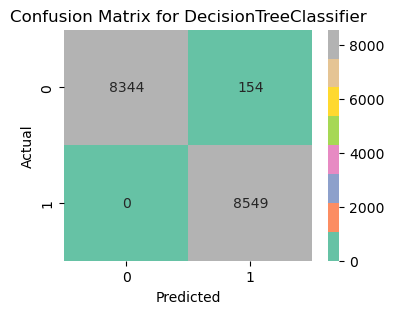

Score for RandomForestClassifier on train data: 0.9995307023332893
Score for RandomForestClassifier on test data: 0.9966563031618466
Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8498
           1       0.99      1.00      1.00      8549

    accuracy                           1.00     17047
   macro avg       1.00      1.00      1.00     17047
weighted avg       1.00      1.00      1.00     17047



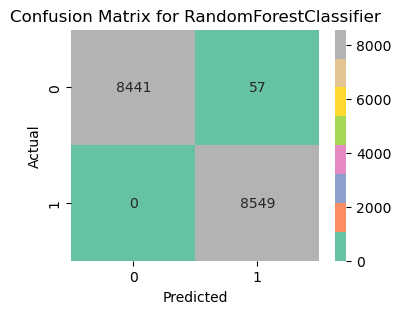

Score for KNeighborsClassifier on train data: 1.0
Score for KNeighborsClassifier on test data: 0.9896169413973133
Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8498
           1       0.98      1.00      0.99      8549

    accuracy                           0.99     17047
   macro avg       0.99      0.99      0.99     17047
weighted avg       0.99      0.99      0.99     17047



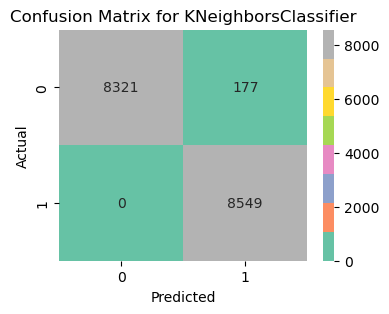

In [87]:
# Models
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=40, max_features='log2', min_samples_leaf=1, min_samples_split=5, random_state=42)
rfc_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=1)

models = [dt_model, rfc_model, knn_model]

# Fit models
for model in models:
    model.fit(X_train, y_train)

# Evaluate models
for model in models:
    model_name = type(model).__name__
    print(f"Score for {model_name} on train data: {model.score(X_train, y_train)}")
    print(f"Score for {model_name} on test data: {model.score(X_test, y_test)}")

    y_predicted = model.predict(X_test)
    print(f"Report for {model_name}:\n{classification_report(y_test, y_predicted)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette("Set2", as_cmap=True))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In our analysis, we evaluated multiple classifiers to predict stroke risk, including DecisionTreeClassifier, RandomForestClassifier, and KNeighborsClassifier. The Random Forest model outperformed the others, delivering superior results across all metrics.

The Decision Tree model achieved an accuracy of 0.99 on the test data. It showed strong performance with a precision of 1.00 for non-stroke cases and 0.98 for stroke cases, and a recall of 0.98 for non-stroke cases and 1.00 for stroke cases.

The Random Forest model demonstrated the best performance, with an accuracy of 0.9967 on the test data. The precision for non-stroke cases was 1.00 and 0.99 for stroke cases, while the recall was 0.99 for non-stroke cases and 1.00 for stroke cases. This indicates the model's exceptional ability to correctly identify stroke risk, with very few false positives or negatives.

KNeighborsClassifier also performed well, with an accuracy of 0.9896 on the test data. It achieved a precision of 1.00 for non-stroke cases and 0.98 for stroke cases, and a recall of 0.98 for non-stroke cases and 1.00 for stroke cases.

Given these results, we decided to use the Random Forest model for further analysis and reporting. Its high accuracy and balanced performance make it the most reliable model for predicting stroke risk. We will use this model to gather all relevant metrics and insights for our final evaluation.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8498
           1       0.99      1.00      1.00      8549

    accuracy                           1.00     17047
   macro avg       1.00      1.00      1.00     17047
weighted avg       1.00      1.00      1.00     17047


Confusion Matrix:
[[8441   57]
 [   0 8549]]
Balanced accuracy: 0.9966462697105201
Precision score for "Yes": 0.9933767139205205
Precision score for "No": 1.0
Recall score for "Yes": 1.0
Recall score for "No": 0.9932925394210402


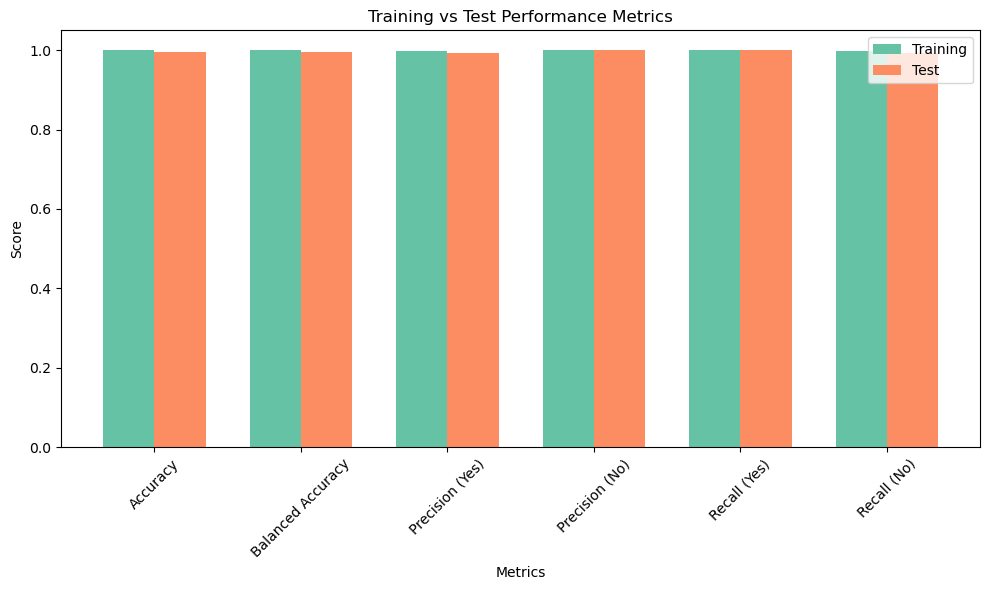

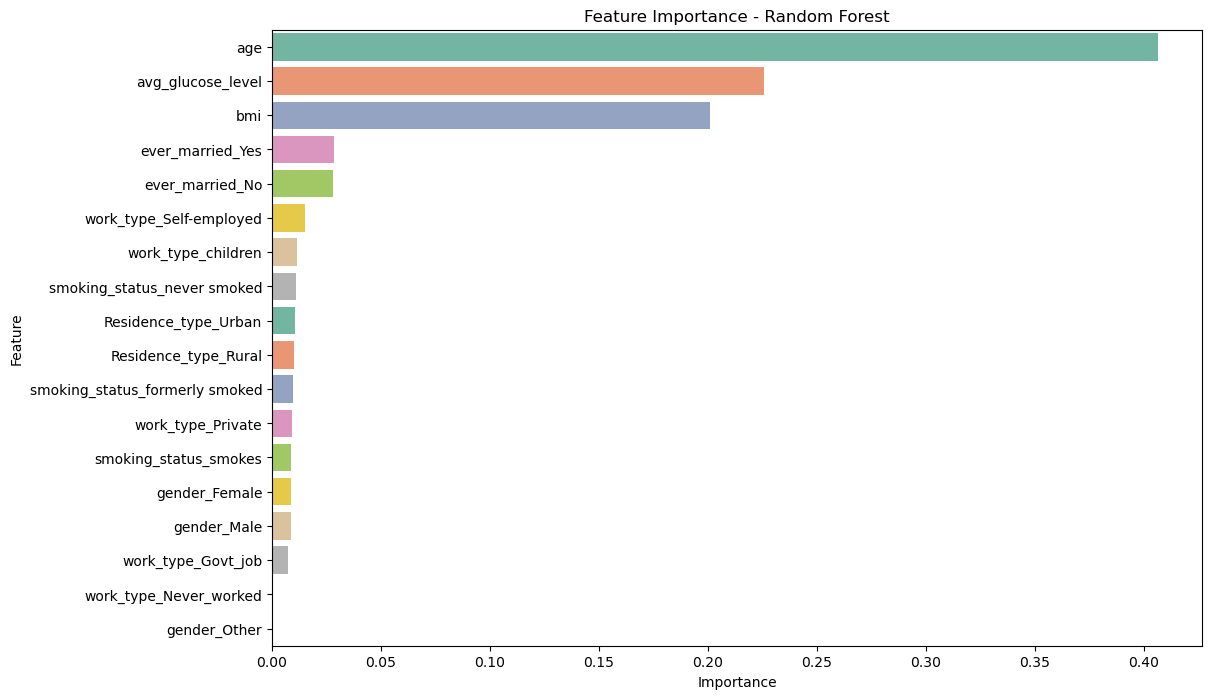

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfc_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
rfc_model.fit(X_train, y_train)

# Predictions
y_pred_train = rfc_model.predict(X_train)
y_pred_test = rfc_model.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Print additional metrics
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_test))
print('Precision score for "Yes":', precision_score(y_test, y_pred_test, pos_label=1))
print('Precision score for "No":', precision_score(y_test, y_pred_test, pos_label=0))
print('Recall score for "Yes":', recall_score(y_test, y_pred_test, pos_label=1))
print('Recall score for "No":', recall_score(y_test, y_pred_test, pos_label=0))

# Metrics on training and test sets
train_metrics = [
    accuracy_score(y_train, y_pred_train),
    balanced_accuracy_score(y_train, y_pred_train),
    precision_score(y_train, y_pred_train, pos_label=1),
    precision_score(y_train, y_pred_train, pos_label=0),
    recall_score(y_train, y_pred_train, pos_label=1),
    recall_score(y_train, y_pred_train, pos_label=0)
]
test_metrics = [
    accuracy_score(y_test, y_pred_test),
    balanced_accuracy_score(y_test, y_pred_test),
    precision_score(y_test, y_pred_test, pos_label=1),
    precision_score(y_test, y_pred_test, pos_label=0),
    recall_score(y_test, y_pred_test, pos_label=1),
    recall_score(y_test, y_pred_test, pos_label=0)
]
metrics_names = ['Accuracy', 'Balanced Accuracy', 'Precision (Yes)', 'Precision (No)', 'Recall (Yes)', 'Recall (No)']

# Plotting training vs test performance metrics
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics_names))

# Use colors from the "Set2" palette
train_color = sns.color_palette("Set2")[0]
test_color = sns.color_palette("Set2")[1]

ax.bar(index, train_metrics, bar_width, label='Training', color=train_color)
ax.bar([i + bar_width for i in index], test_metrics, bar_width, label='Test', color=test_color)
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance Metrics')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metrics_names, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

# Feature Importance
importances = rfc_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=sns.color_palette("Set2"))
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Conclusion

In this analysis, we evaluated three machine learning models for stroke prediction: Random Forest, Decision Tree, and K-Nearest Neighbors (KNN).

Random Forest emerged as the most effective model, achieving the highest accuracy and balanced accuracy. Its robustness and precision make it ideal for minimizing false negatives and false positives, which is crucial in clinical settings.

Decision Tree showed strong performance, while slightly less effective than Random Forest, it offers valuable interpretability, aiding in understanding decision paths.

K-Nearest Neighbors (KNN) displayed variable performance, with accuracy declining as the number of neighbors increased. It achieved its best results with 99% accuracy at n_neighbors = 1, but its stability decreases with higher values, making it less suitable for complex datasets.

In conclusion, the Random Forest model is recommended for stroke prediction due to its superior accuracy and reliability, providing an excellent tool for healthcare professionals or others to assess patient risk accurately and implement timely interventions.

## Implementation

The application of stroke prediction models can significantly impact various sectors:

Clinical/Hospitals: Integrating predictive models into electronic health records (EHR) can help clinicians identify high-risk patients early, allowing for targeted interventions and personalized care plans, ultimately improving patient outcomes.

Insurance Companies: Utilizing these models for risk assessment can enable more accurate premium pricing and the development of preventative health programs. This approach helps in mitigating costs associated with stroke-related claims and promotes healthier lifestyles among policyholders.

Biotech Companies: By incorporating stroke prediction models into health monitoring devices, biotech firms can provide users with real-time risk assessments, facilitating timely lifestyle adjustments and medical consultations. This integration supports preventive healthcare and enhances user engagement.

These implementations demonstrate the broad applicability of stroke prediction models, highlighting their potential to improve healthcare delivery, reduce costs, and foster innovation across various industries

## Future Work

In the ongoing pursuit of enhancing stroke prediction, several avenues for future research and development are proposed. First, incorporating larger and more diverse datasets could improve model generalizability and accuracy across different populations. Additionally, exploring advanced modeling techniques such as ensemble learning and neural networks may further refine predictive capabilities.

Another promising area is integrating real-time data from wearable health devices, which could enable continuous monitoring and early intervention for at-risk individuals. Finally, collaboration with healthcare professionals to validate and fine-tune these models in clinical settings will be crucial for practical implementation, ensuring that predictive tools are both accurate and actionable in real-world applications.